In [9]:
import numpy as np
from scipy.cluster.hierarchy import fcluster
import numpy as np
from gurobipy import Model, GRB, quicksum
import gurobipy as gp

gp.setParam('OutputFlag', 0)

In [10]:

# Example item volumes and container capacities
item_volumes = np.random.randint(1, 150, size=10)  # Use smaller number for debugging
item_volumes_2  = item_volumes.copy()
container_capacities = [50, 100, 150]

def compute_initial_distance_matrix(volumes, capacities):
    n = len(volumes)
    distance_matrix = np.full((n, n), np.inf)
    for i in range(n):
        for j in range(i + 1, n):
            combined_volume = volumes[i] + volumes[j]
            min_dist = np.inf
            for capacity in capacities:
                if combined_volume <= capacity:
                    distance = capacity - combined_volume
                    if distance < min_dist:
                        min_dist = distance
            if min_dist < np.inf:
                distance_matrix[i, j] = min_dist
                distance_matrix[j, i] = min_dist
    return distance_matrix

def update_distance_matrix(distance_matrix, i, j, new_index, volumes, capacities,is_clustered):
    n = distance_matrix.shape[0]
    new_distances = np.full(n + 1, np.inf)
    combined_volume = volumes[i] + volumes[j]
    for k in range(n):
        if k != i and k != j:
            if  k in is_clustered and is_clustered[k] != True : 
                combined_volume_with_k = combined_volume + volumes[k]
                min_dist = np.inf
                for capacity in capacities:
                    if combined_volume_with_k <= capacity:
                        distance = capacity - combined_volume_with_k
                        if distance < min_dist:
                            min_dist = distance
                new_distances[k] = min_dist
            #distance_matrix[k, new_index] = min_dist
    
    new_distances[new_index] = np.inf
    new_distance_matrix = np.pad(distance_matrix, ((0, 1), (0, 1)), mode='constant', constant_values=np.inf)
    new_distance_matrix[new_index, :] = new_distances
    new_distance_matrix[:, new_index] = new_distances


    # Set distances to i and j to infinity
    new_distance_matrix[i, :] = np.inf
    new_distance_matrix[:, i] = np.inf
    new_distance_matrix[j, :] = np.inf
    new_distance_matrix[:, j] = np.inf
    
    return new_distance_matrix



def simulate_clustering(item_volumes, container_capacities):
    n = len(item_volumes)
    distance_matrix = compute_initial_distance_matrix(item_volumes, container_capacities)
    item_volumes = list(item_volumes)  # Convert to list for easier manipulation
    clusters = {i: [i] for i in range(n)}
    cluster_clarifier = {i: i for i in range(n)}
    is_clustered = {i: False for i in range(n)}
    Z = []

    while len(clusters) > 1:
        i, j = np.unravel_index(np.argmin(distance_matrix), distance_matrix.shape)
        if distance_matrix[i, j] == np.inf:  # No more valid merges
            break

        min_dist = distance_matrix[i, j]
        new_index = len(item_volumes)
        new_cluster_volume = item_volumes[i] + item_volumes[j]
        item_volumes.append(new_cluster_volume)
        clusters[new_index] = clusters.pop(cluster_clarifier[i]) + clusters.pop(cluster_clarifier[j])
        cluster_clarifier[i] = new_index
        cluster_clarifier[j] = new_index
        cluster_clarifier[new_index] = new_index
        is_clustered[i] = True
        is_clustered[j] = True

        Z.append([i, j, min_dist, len(clusters[cluster_clarifier[i]]) + len(clusters[cluster_clarifier[j]])])

        distance_matrix = update_distance_matrix(distance_matrix, i, j, new_index, item_volumes, container_capacities, is_clustered)
        distance_matrix[i, :] = np.inf
        distance_matrix[:, i] = np.inf
        distance_matrix[j, :] = np.inf
        distance_matrix[:, j] = np.inf
    
    return clusters, Z

In [11]:
def simulate_container_assignment_exact(item_volumes, container_capacities, binary_vars=True):
    num_items = len(item_volumes)
    num_container_types = len(container_capacities)

    # Create a new model
    model = Model("container_assignment")

    # Decision variables
    if binary_vars:
        vtype = GRB.BINARY
    else:
        vtype = GRB.CONTINUOUS

    # x[i, j, k] = 1 if item i is in container j of type k
    x = model.addVars(num_items, num_items, num_container_types, vtype=vtype, name="x")

    # y[j, k] = 1 if container j of type k is used
    y = model.addVars(num_items, num_container_types, vtype=GRB.BINARY, name="y")

    # Objective: minimize the total number of containers used
    model.setObjective(quicksum(y[j, k] for j in range(num_items) for k in range(num_container_types)), GRB.MINIMIZE)

    # Constraints
    # Each item must be placed in exactly one container
    for i in range(num_items):
        model.addConstr(quicksum(x[i, j, k] for j in range(num_items) for k in range(num_container_types)) == 1, name=f"item_{i}")

    # The total volume of items in each container must not exceed its capacity
    for j in range(num_items):
        for k in range(num_container_types):
            model.addConstr(quicksum(x[i, j, k] * item_volumes[i] for i in range(num_items)) <= container_capacities[k] * y[j, k], name=f"capacity_{j}_{k}")

    # Optimize model
    model.optimize()

    # Extract results
    if model.status == GRB.OPTIMAL:
        container_counts = {capacity: 0 for capacity in container_capacities}
        for j in range(num_items):
            for k in range(num_container_types):
                if y[j, k].X > 0.5:
                    container_counts[container_capacities[k]] += 1

        total_containers = sum(container_counts.values())
        return container_counts, total_containers
    else:
        print("No optimal solution found")
        return None, None



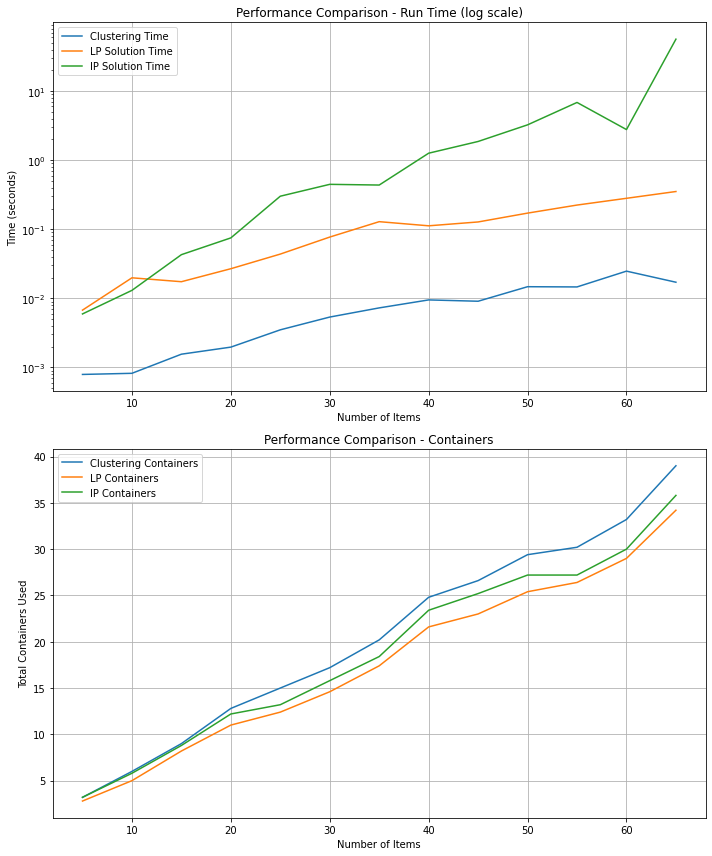

In [12]:

import numpy as np
import time
import matplotlib.pyplot as plt

def generate_performance_data(min_items, max_items, step, num_repeats=5):
    num_items_list = range(min_items, max_items + 1, step)
    clustering_times = []
    lp_times = []
    mip_times = []
    clustering_containers = []
    lp_containers = []
    mip_containers = []

    for num_items in num_items_list:
        clustering_time_list = []
        lp_time_list = []
        mip_time_list = []
        clustering_containers_list = []
        lp_containers_list = []
        mip_containers_list = []

        for _ in range(num_repeats):
            item_volumes = np.random.randint(1, 150, size=num_items)
            container_capacities = [50, 100, 150]

            # Clustering
            start_time = time.time()
            clusters, _ = simulate_clustering(item_volumes, container_capacities)
            clustering_time = time.time() - start_time
            clustering_time_list.append(clustering_time)
            clustering_containers_list.append(len(clusters))

            # LP solution
            start_time = time.time()
            _, lp_total_containers = simulate_container_assignment_exact(item_volumes, container_capacities, binary_vars=False)
            lp_time = time.time() - start_time
            lp_time_list.append(lp_time)
            lp_containers_list.append(lp_total_containers)

            # MIP solution
            start_time = time.time()
            _, mip_total_containers = simulate_container_assignment_exact(item_volumes, container_capacities, binary_vars=True)
            mip_time = time.time() - start_time
            mip_time_list.append(mip_time)
            mip_containers_list.append(mip_total_containers)

        clustering_times.append(np.mean(clustering_time_list))
        lp_times.append(np.mean(lp_time_list))
        mip_times.append(np.mean(mip_time_list))
        clustering_containers.append(np.mean(clustering_containers_list))
        lp_containers.append(np.mean(lp_containers_list))
        mip_containers.append(np.mean(mip_containers_list))

    return num_items_list, clustering_times, lp_times, mip_times, clustering_containers, lp_containers, mip_containers

def plot_performance(num_items_list, clustering_times, lp_times, mip_times, clustering_containers, lp_containers, mip_containers):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
    ax1.plot(num_items_list, clustering_times, label='Clustering Time')
    ax1.plot(num_items_list, lp_times, label='LP Solution Time')
    ax1.plot(num_items_list, mip_times, label='IP Solution Time')
    ax1.set_xlabel('Number of Items')
    ax1.set_ylabel('Time (seconds)')
    ax1.set_title('Performance Comparison - Run Time (log scale)')
    ax1.legend()
    ax1.grid(True)
    ax1.set_yscale('log')

    
    ax2.plot(num_items_list, clustering_containers, label='Clustering Containers')
    ax2.plot(num_items_list, lp_containers, label='LP Containers')
    ax2.plot(num_items_list, mip_containers, label='IP Containers')
    ax2.set_xlabel('Number of Items')
    ax2.set_ylabel('Total Containers Used')
    ax2.set_title('Performance Comparison - Containers')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Kullanım Örneği
min_items = 5 
max_items = 65
step = 5
num_repeats = 5

num_items_list, clustering_times, lp_times, mip_times, clustering_containers, lp_containers, mip_containers = generate_performance_data(min_items, max_items, step, num_repeats)
plot_performance(num_items_list, clustering_times, lp_times, mip_times, clustering_containers, lp_containers, mip_containers)



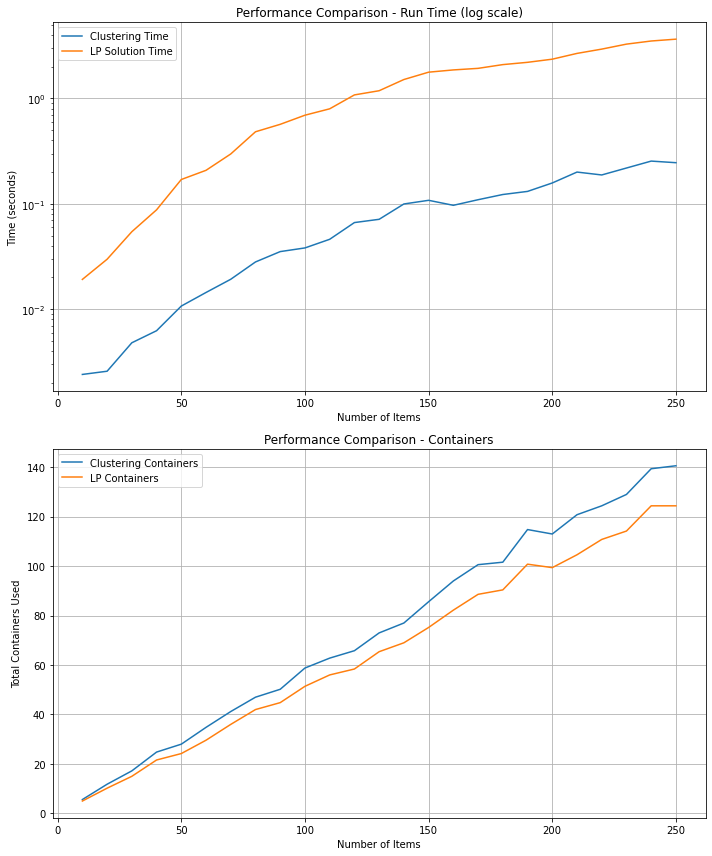

In [13]:

import numpy as np
import time
import matplotlib.pyplot as plt

def generate_performance_data(min_items, max_items, step, num_repeats=5):
    num_items_list = range(min_items, max_items + 1, step)
    clustering_times = []
    lp_times = []
    mip_times = []
    clustering_containers = []
    lp_containers = []
    mip_containers = []

    for num_items in num_items_list:
        clustering_time_list = []
        lp_time_list = []
        mip_time_list = []
        clustering_containers_list = []
        lp_containers_list = []
        mip_containers_list = []

        for _ in range(num_repeats):
            item_volumes = np.random.randint(1, 150, size=num_items)
            container_capacities = [50, 100, 150]

            # Clustering
            start_time = time.time()
            clusters, _ = simulate_clustering(item_volumes, container_capacities)
            clustering_time = time.time() - start_time
            clustering_time_list.append(clustering_time)
            clustering_containers_list.append(len(clusters))

            # LP solution
            start_time = time.time()
            _, lp_total_containers = simulate_container_assignment_exact(item_volumes, container_capacities, binary_vars=False)
            lp_time = time.time() - start_time
            lp_time_list.append(lp_time)
            lp_containers_list.append(lp_total_containers)


        clustering_times.append(np.mean(clustering_time_list))
        lp_times.append(np.mean(lp_time_list))
        clustering_containers.append(np.mean(clustering_containers_list))
        lp_containers.append(np.mean(lp_containers_list))


    return num_items_list, clustering_times, lp_times, clustering_containers, lp_containers

def plot_performance(num_items_list, clustering_times, lp_times, clustering_containers, lp_containers):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
    ax1.plot(num_items_list, clustering_times, label='Clustering Time')
    ax1.plot(num_items_list, lp_times, label='LP Solution Time')
    ax1.set_xlabel('Number of Items')
    ax1.set_ylabel('Time (seconds)')
    ax1.set_title('Performance Comparison - Run Time (log scale)')
    ax1.legend()
    ax1.grid(True)
    ax1.set_yscale('log')

    
    ax2.plot(num_items_list, clustering_containers, label='Clustering Containers')
    ax2.plot(num_items_list, lp_containers, label='LP Containers')
    ax2.set_xlabel('Number of Items')
    ax2.set_ylabel('Total Containers Used')
    ax2.set_title('Performance Comparison - Containers')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Kullanım Örneği
min_items = 10 
max_items = 250
step = 10
num_repeats = 5

num_items_list, clustering_times, lp_times, clustering_containers, lp_containers = generate_performance_data(min_items, max_items, step, num_repeats)
plot_performance(num_items_list, clustering_times, lp_times, clustering_containers, lp_containers)



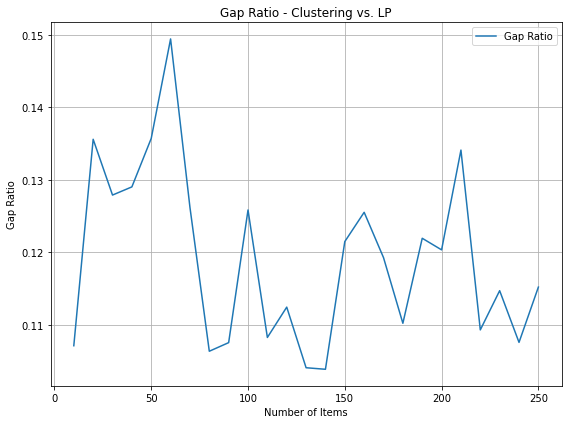

In [20]:
gap_ratios = [(clustering_containers[i] - lp_containers[i]) / clustering_containers[i] for i in range(len(num_items_list))]
gap_ratios

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(num_items_list, gap_ratios, label='Gap Ratio')
ax.set_xlabel('Number of Items')
ax.set_ylabel('Gap Ratio')
ax.set_title('Gap Ratio - Clustering vs. LP')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()